# **UNet Segmentation TEST (inference)**
### *Keras / Tensorflow 2*

*thomas.grenier@creatis.insa-lyon.fr*

Here, we load a pre-trained model based on UNet architecture that allows image segmentation.
UNet was initially proposed by Ronneberger in 2015 and is now the most used architecture for semantic image segmentation.

### <span style="color:brown"> **What is segmentation ?**

Segmentation is the process of assigning a label (that represents a class or an object) to a pixel.

If there is only one kind of object, segmentation is said to be a binary segmentation (ie object and backgrouond).
For more classes, segmentation is said multi-class segmenation.

The next figure illustrated available MRI images (WIP mDixon axial BW036 2nsa sshot HR2 TE2_3 FFE CLEAR, echo 2, 5 and 8) of shoulder from Geneva Hospital with the manual segmentation of 5 muscles done by experts (Jean-Baptiste Pialat, Lexane Rocle, Jeff Delorme):

<img src="figures/P02_71_e2_crop.png" alt="Segmentation" style="width: 22%;"/> <img src="figures/P02_71_e5_crop.png" alt="Segmentation" style="width: 22%;"/> <img src="figures/P02_71_e8_crop.png" alt="Segmentation" style="width: 22%;"/> <img src="figures/P02_71_crop.png" alt="Segmentation" style="width: 22%;"/>
    

In the following, we are going to segment in 2D these 5 muscles on such MRI (mainly using echo 8 images).

### <span style="color:brown"> **What is the difference between semantic segmentation and instance segmentation ?**

If several objects of the same class are present in an image, semantic segmentation assigns the same class to all these objects.
Instance segmentation will also dissociate each of these objects and allows a direct count of them.
One can note that the step of dissociation (or counting) can be done by classical image processing methods after a semantic segmentation.

<img src="figures/SemanticIntanceSegmentation.png" alt="Semantic vs Instance Segmentation" style="width: 75%;"/>    

**Here we focus on multi-class semantic segmentation** using U-Net deep neural network.

### <span style="color:brown"> **Unet in (very) brief**
This Network is fully **convolutional**. 
It uses skip connections from the encoder side to the decoder side to preserve scale information.

<img src="figures/UNet.png" alt="UNet" style="width: 70%;"/>

In this notebook, we start by using a trained network.


### <span style="color:red"> Question : </span> On the last convolution layer, how many filters are needed to segment our 5 muscles ?

## <span style="color:brown"> **1- System setting**

We start by loading necessary libraries and setting variables.
Some of them are related to data.
But, to ensure that the code works on almost all infrastructures, low-level system variable are also initialized. 

In [1]:
!pip install medpy
!pip install tqdm
!pip install opencv-python

     |████████████████████████████████| 151 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 48.4 MB 19.3 MB/s eta 0:00:01
  Created wheel for medpy: filename=MedPy-0.4.0-py3-none-any.whl size=214963 sha256=619dd2e089807500de403a5e5c6f60939b145d39f594c8def377453b2e58d080
  Stored in directory: /home/jovyan/.cache/pip/wheels/41/46/a2/7c585b78f216a3dd8723dbab5f439822fa5dfbff563757a49e
Successfully built medpy
     |████████████████████████████████| 78 kB 3.6 MB/s eta 0:00:011


In [2]:
import glob
import os
import sys
from datetime import datetime

from tqdm import tqdm 

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,15)

import cv2
import tensorflow as tf

2022-07-06 19:23:21.339892: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
if 'model' in locals(): 
    print("deleting model")
    del model    
    
# select the device (CPU or GPU) to run on
num_CPU = 1
num_cores = 4

# KERNEL msut be restarted if you change GPU 0 -> 1 or 1 -> 0 (cannot change runtime after initialization)
GPU = 1  # GPU = 0 : CPU Only ; GPU = 1 : use GPU

physical_gpu_devices = tf.config.list_physical_devices('GPU')
physical_cpu_devices = tf.config.list_physical_devices('CPU')
print(physical_gpu_devices)
print(physical_cpu_devices)

if GPU:
    tf.config.set_visible_devices(physical_gpu_devices[0], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    print(visible_devices)  
    for device in visible_devices:
        print(device)
    tf.config.threading.set_intra_op_parallelism_threads(num_CPU)
    tf.config.threading.set_inter_op_parallelism_threads(num_cores) 
else:
    try:
      # Disable all GPUS
      tf.config.set_visible_devices([], 'GPU')
      visible_devices = tf.config.get_visible_devices()
      for device in visible_devices:
        print(device)
        assert device.device_type != 'GPU'
    except:
      # Invalid device or cannot modify virtual devices once initialized.
      pass
    tf.config.threading.set_intra_op_parallelism_threads(num_CPU)
    tf.config.threading.set_inter_op_parallelism_threads(num_cores)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2022-07-06 19:24:19.714769: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-06 19:24:19.715715: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-06 19:24:19.785157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 19:24:19.785774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-07-06 19:24:19.785811: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-06 19:24:19.787632: I tensorflow/stream_executor/platform/default/dso_loade

## <span style="color:brown"> **2- Load and Prepare images and model**

<span style="color:red">
    
> **Before running cells of 2.1**, you have to   
>   1. if not in the current directory, download the file ```dlss21_ho4_data.tar.gz```  ( can be done on linux bash with ```$ wget https://gitlab.in2p3.fr/thomas.grenier/tp4ss_segmentation/-/raw/master/dlss21_ho4_data.tar.gz```)
>   2. un tar the downloaded file in the directory of this notebook (to do so on bash : ```$ tar xzf dlss21_ho4_data.tar.gz```).

The next cell can do it for you:

In [4]:
# the following commands work on linux system and download the file
!rm dlss21_ho4_data.tar.gz
!wget https://gitlab.in2p3.fr/thomas.grenier/tp4ss_segmentation/-/raw/master/dlss21_ho4_data.tar.gz
!tar fax dlss21_ho4_data.tar.gz

rm: cannot remove 'dlss21_ho4_data.tar.gz': No such file or directory
--2022-07-06 19:24:50--  https://gitlab.in2p3.fr/thomas.grenier/tp4ss_segmentation/-/raw/master/dlss21_ho4_data.tar.gz
Resolving gitlab.in2p3.fr (gitlab.in2p3.fr)... 134.158.69.41
Connecting to gitlab.in2p3.fr (gitlab.in2p3.fr)|134.158.69.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122210912 (117M) [application/x-gzip]
Saving to: ‘dlss21_ho4_data.tar.gz’

dlss21_ho4_data.tar 100%[===================>] 116.55M  26.9MB/s    in 5.6s    

2022-07-06 19:24:56 (20.6 MB/s) - ‘dlss21_ho4_data.tar.gz’ saved [122210912/122210912]



<span style="color:red">
    
> **Before running the cells of 2.1**, you have to download the **MODEL** ```dlss21_ho4_model```:
>    1.  link : https://www.creatis.insa-lyon.fr/~grenier/wp-content/uploads/teaching/DeepLearning/Unet_f32_b16_l5_do0.1_Std_BN_input96.h5
>    2.  copy in the directory than this notebook.
    
The next cell can do it for you:

In [5]:
# the following command works on linux and download the model
!wget https://www.creatis.insa-lyon.fr/~grenier/wp-content/uploads/teaching/DeepLearning/Unet_f32_b16_l5_do0.1_Std_BN_input96.h5

--2022-07-06 19:28:53--  https://www.creatis.insa-lyon.fr/~grenier/wp-content/uploads/teaching/DeepLearning/Unet_f32_b16_l5_do0.1_Std_BN_input96.h5
Resolving www.creatis.insa-lyon.fr (www.creatis.insa-lyon.fr)... 195.220.108.5
Connecting to www.creatis.insa-lyon.fr (www.creatis.insa-lyon.fr)|195.220.108.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 498227808 (475M) [application/mipc]
Saving to: ‘Unet_f32_b16_l5_do0.1_Std_BN_input96.h5’

Unet_f32_b16_l5_do0 100%[===================>] 475.15M  9.96MB/s    in 55s     

2022-07-06 19:29:48 (8.70 MB/s) - ‘Unet_f32_b16_l5_do0.1_Std_BN_input96.h5’ saved [498227808/498227808]



## <span style="color:brown"> 2.1- Load data

In [6]:
from keras_unet.utils import ReadImages, ReadMasks

In [7]:
# test 
test_masks_files     = glob.glob("./dlss21_ho4_data/test/labels/*.png")
test_images_e8_files = glob.glob("./dlss21_ho4_data/test/images/*_e8.png")
test_images_e5_files = glob.glob("./dlss21_ho4_data/test/images/*_e5.png")
test_images_e2_files = glob.glob("./dlss21_ho4_data/test/images/*_e2.png")

# Data related values
IMG_SIZE = 96

JUPYTER_DISPLAY_ON = True

model_filename = './Unet_f32_b16_l5_do0.1_Std_BN_input96.h5'

In [8]:
test_images_e2_files.sort()
test_images_e5_files.sort()
test_images_e8_files.sort()
test_masks_files.sort()

print( " testing   :  ", len(test_images_e2_files), len(test_images_e5_files), len(test_images_e8_files), len(test_masks_files) )

permutation_test = np.random.permutation( len(test_masks_files))
test_images_e2_files_rnd=[test_images_e2_files[i] for i in permutation_test]
test_images_e5_files_rnd=[test_images_e5_files[i] for i in permutation_test]
test_images_e8_files_rnd=[test_images_e8_files[i] for i in permutation_test]
test_masks_files_rnd=[test_masks_files[i] for i in permutation_test]   


 testing   :   208 208 208 208


In [9]:
# reading files
X_test_e8 = ReadImages(test_images_e8_files_rnd, size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))
X_test_e5 = ReadImages(test_images_e5_files_rnd, size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))
X_test_e2 = ReadImages(test_images_e2_files_rnd, size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))
y_test = ReadMasks(test_masks_files_rnd, size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))

# 1 MRI
input_shape = (IMG_SIZE, IMG_SIZE, 1)
X_test = X_test_e8

# 3 MRI
#input_shape = (IMG_SIZE, IMG_SIZE, 3)
#X_test = tf.keras.layers.Concatenate()([X_test_e8, X_test_e5, X_test_e2])

100%|██████████| 208/208 [00:00<00:00, 2504.13it/s]


In [10]:
print(" Shape test : ", X_test_e2.shape, X_test_e5.shape, X_test_e8.shape, y_test.shape)
print(" Shape X_test and y_test : ", X_test.shape,  y_test.shape)
print(" Type test : ", X_test_e2.dtype, X_test_e5.dtype, X_test_e8.dtype, y_test.dtype)

 Shape test :  (208, 96, 96, 1) (208, 96, 96, 1) (208, 96, 96, 1) (208, 96, 96, 6)
 Shape X_test and y_test :  (208, 96, 96, 1) (208, 96, 96, 6)
 Type test :  float32 float32 float32 float32


In [11]:
print(test_images_e8_files_rnd[3])
print(test_images_e8_files_rnd[6])

./dlss21_ho4_data/test/images/P19_017_e8.png
./dlss21_ho4_data/test/images/P21_006_e8.png


### <span style="color:red"> Question : </span> Observe the min and max of data. Why range is so critical ?

## <span style="color:brown"> 2.2- Plot images + masks + overlay (mask over original)

Check, check and re-check again your data. 
Many mistakes come from data...

**The following cell displays images, manual annotations and an overlays for ease of visualization**
Nothing done by the network yet!

In [12]:
from keras_unet.visualization import plot_overlay_segmentation, plot_compare_segmentation

### Plot images with overlay (mask over original)

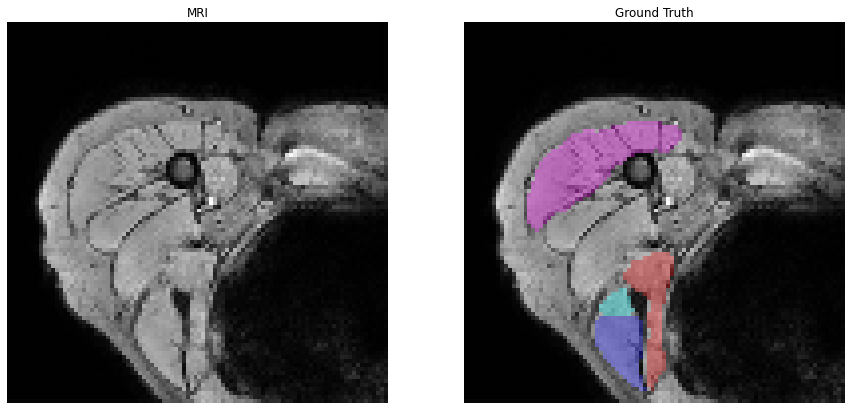

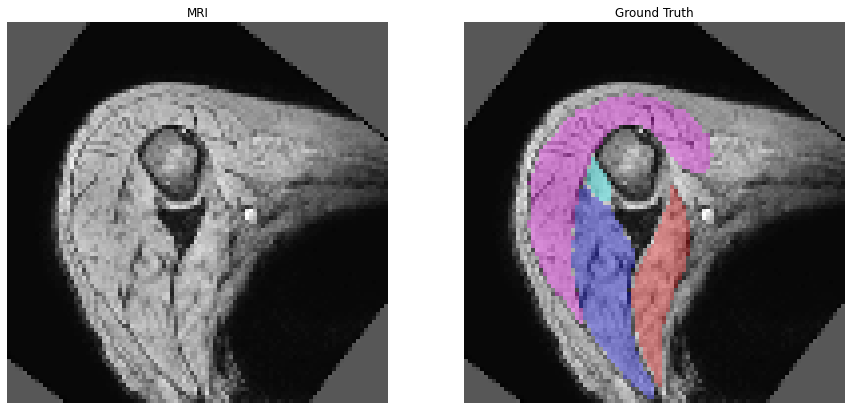

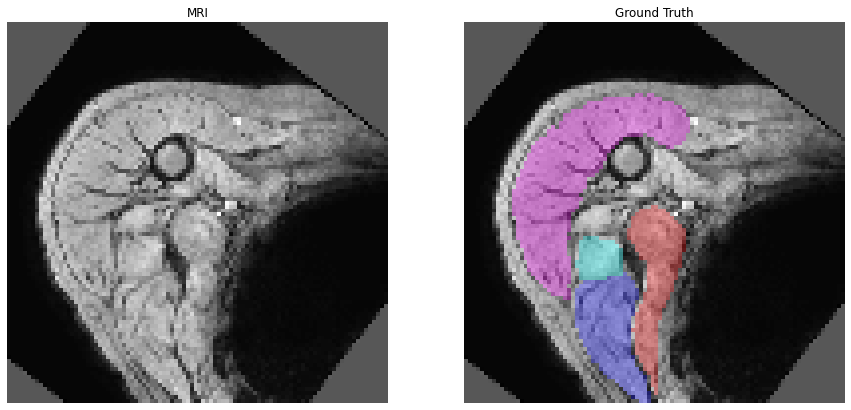

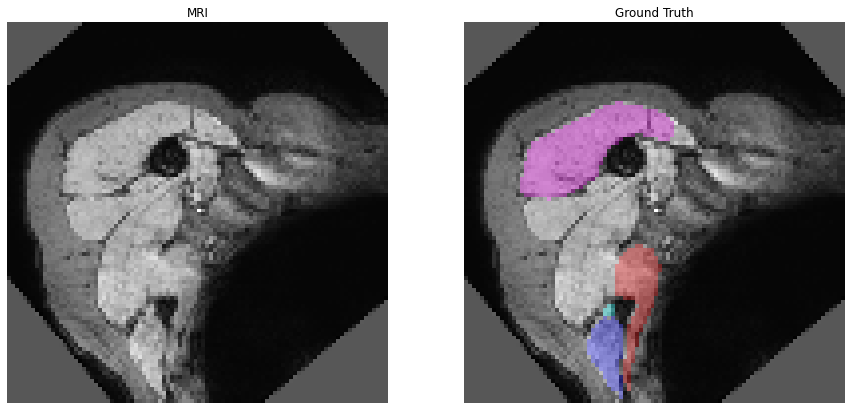

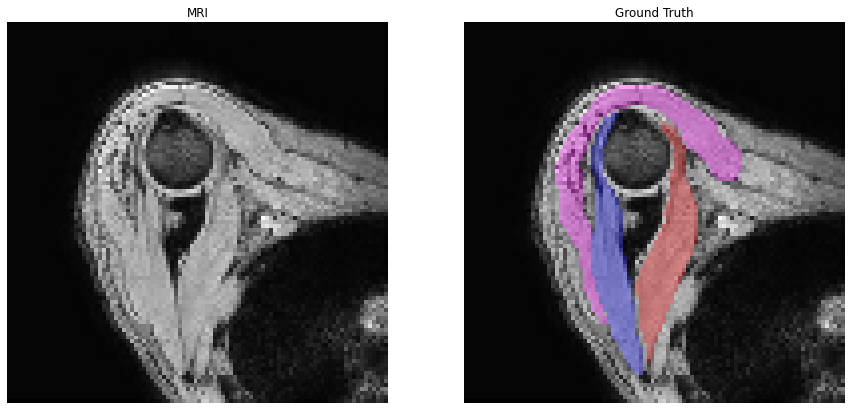

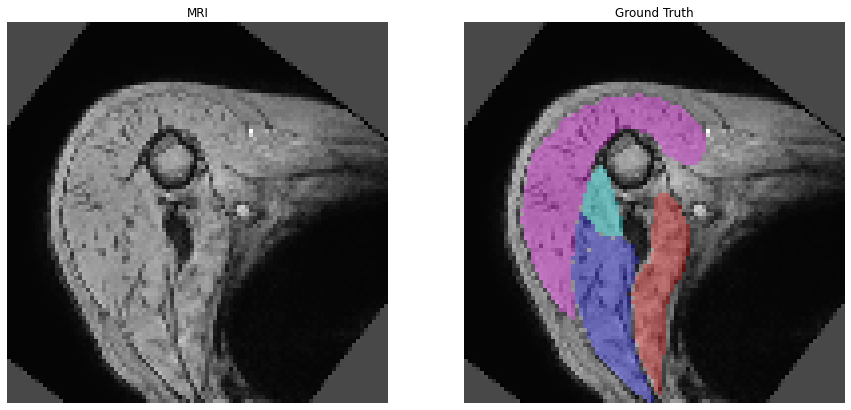

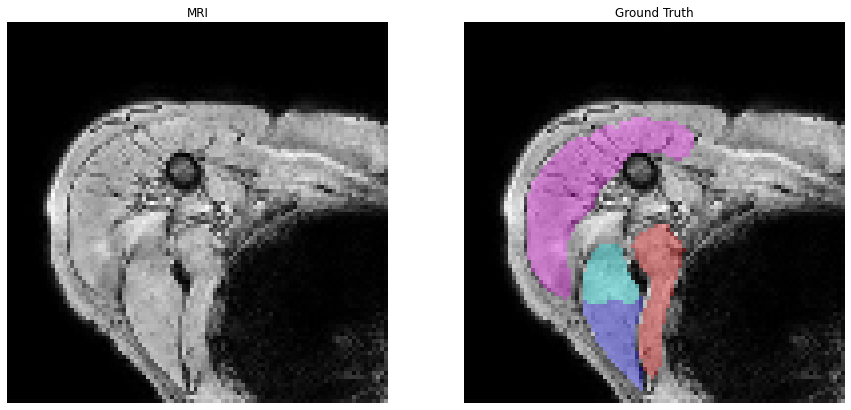

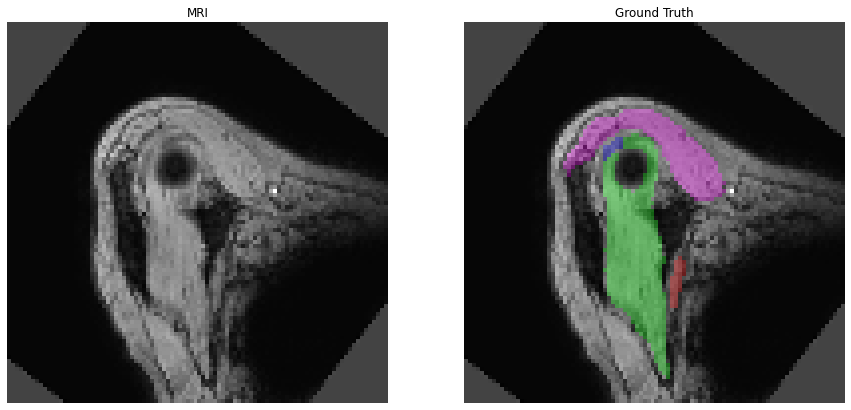

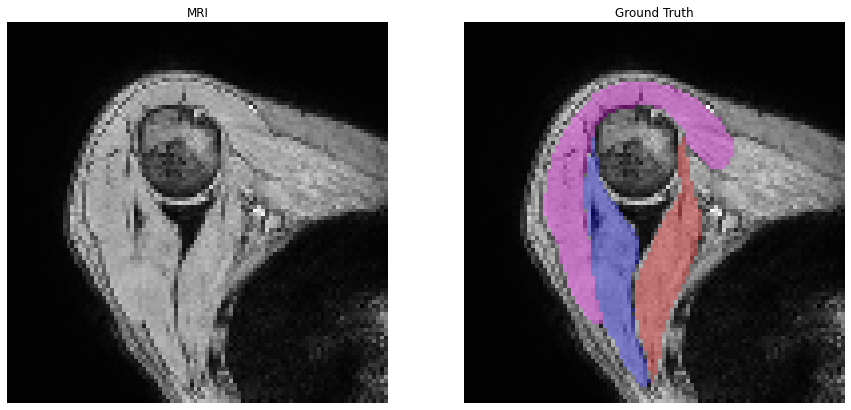

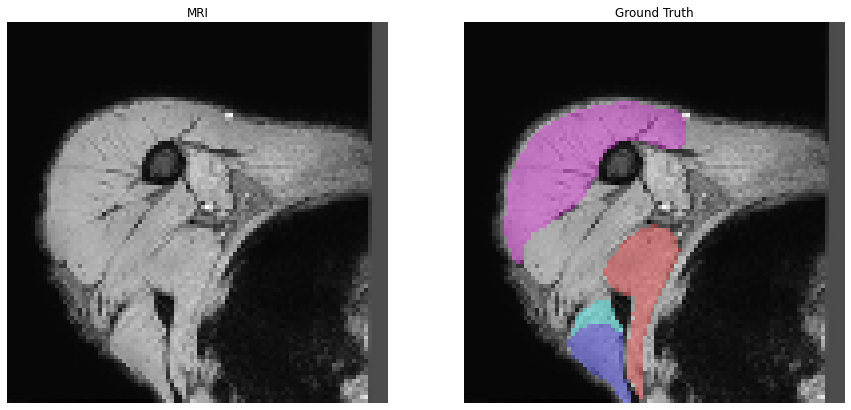

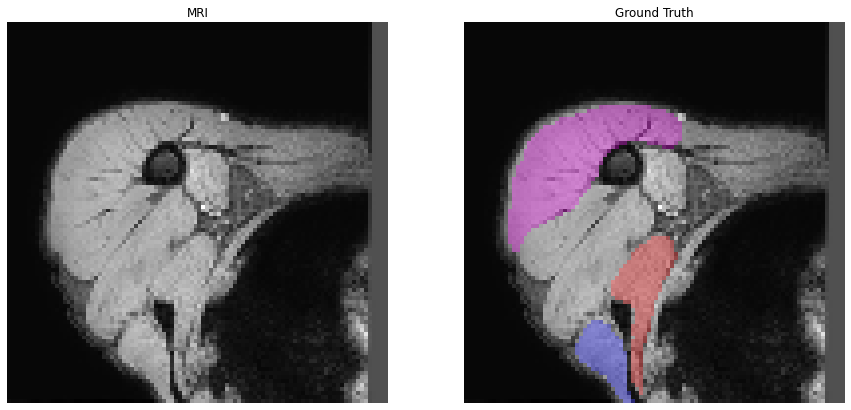

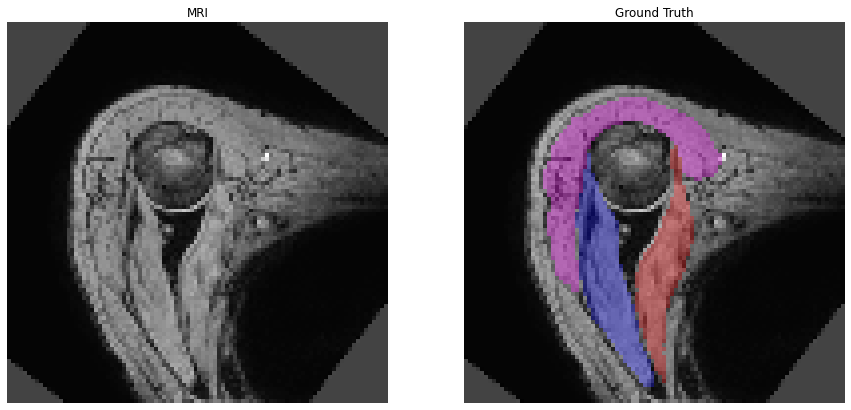

In [13]:
plot_overlay_segmentation(X_test_e8[3:15], y_test[3:15])

## <span style="color:brown"> **3- Load the network and its weights**

In [14]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import dice_loss, dice_coef, adaptive_loss
from tensorflow.keras import models

tf.keras.backend.clear_session()

# load the network with its custom functions
loaded_model = models.load_model(model_filename, custom_objects={'dice_coef': dice_coef, 'adaptive_loss': adaptive_loss, 'dice_loss': dice_loss})

# display the network
loaded_model.summary()


2022-07-06 19:38:53.828365: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 19:38:53.828464: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-06 19:38:53.828655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 19:38:53.829229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
20

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 96, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 96, 96, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

## <span style="color:brown"> **4- Predict segmentations on the whole test set using the network**

In [15]:
y_pred = loaded_model.predict(X_test, batch_size=1, verbose=1) # GPU Size

2022-07-06 19:39:40.583675: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-06 19:39:40.601796: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz
2022-07-06 19:39:41.070453: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-07-06 19:39:42.247650: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-07-06 19:39:42.281935: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-07-06 19:39:42.799377: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


208/208 [==============================] - 13s 6ms/step


In [16]:
loss, dice_coef = loaded_model.evaluate(x=X_test, y=y_test, batch_size=1, verbose=1) # 
print(f"loss : {loss}   dice_coeff : {dice_coef}")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
208/208 [==============================] - 2s 7ms/step - loss: 0.2009 - dice_coef: 0.9286
loss : 0.2009270340204239   dice_coeff : 0.9285910129547119


## <span style="color:brown"> 4.1- Plot images : MRI with overlay of ground truth + MRI with prediction overlay

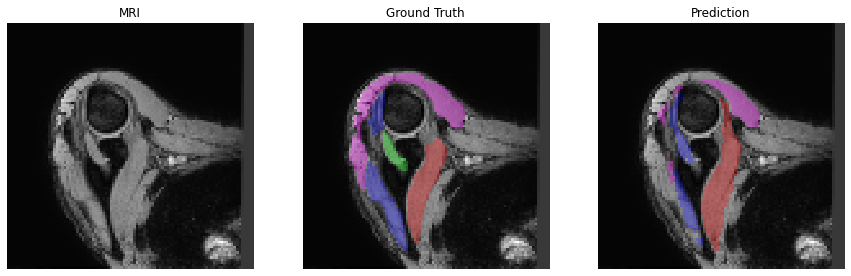

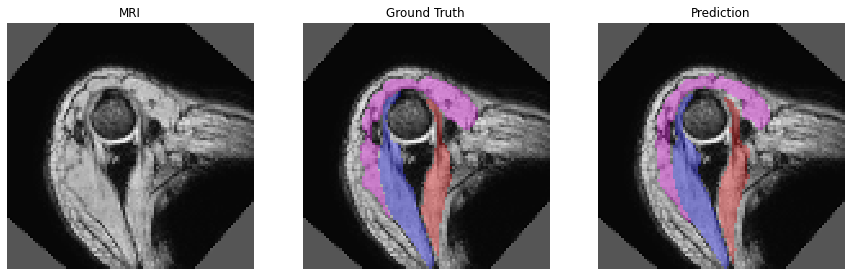

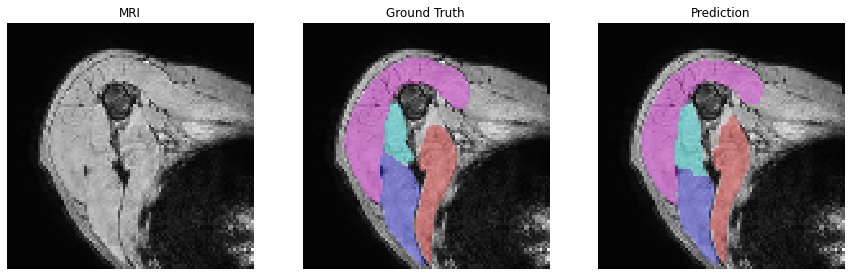

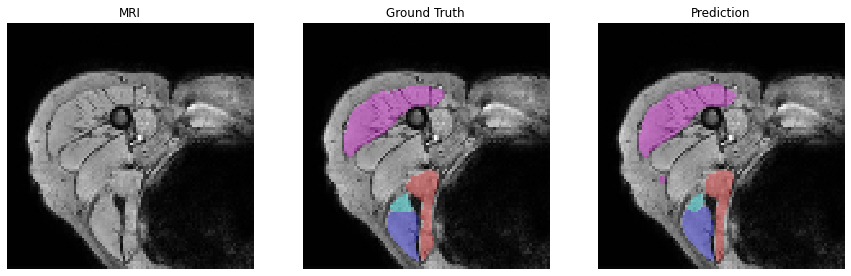

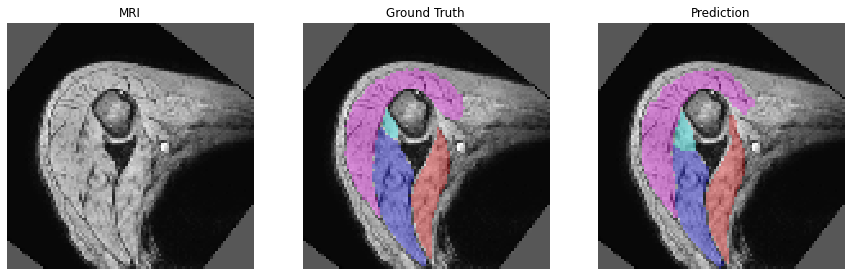

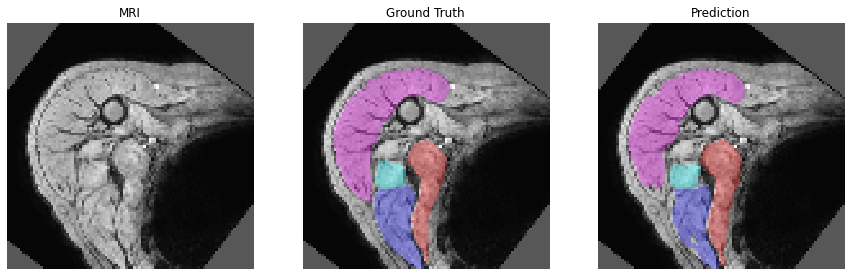

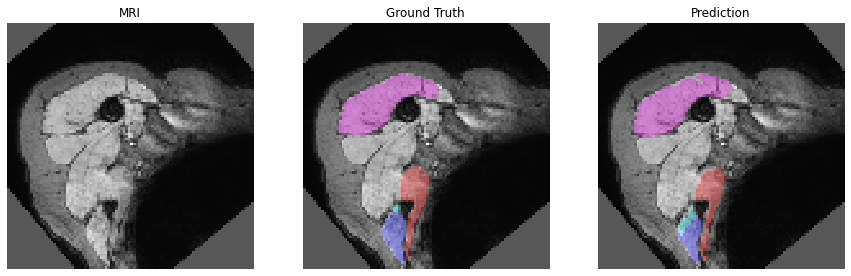

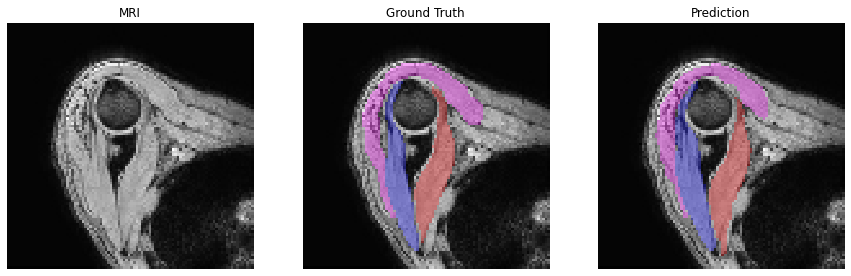

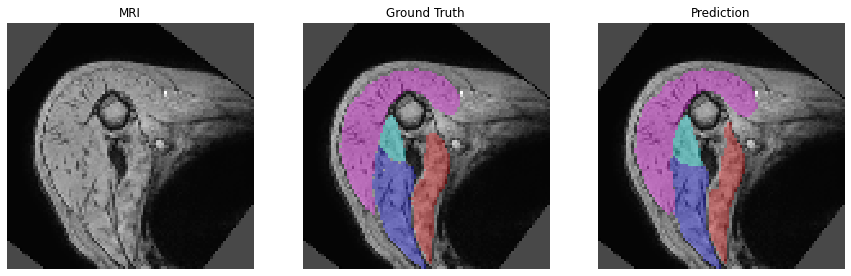

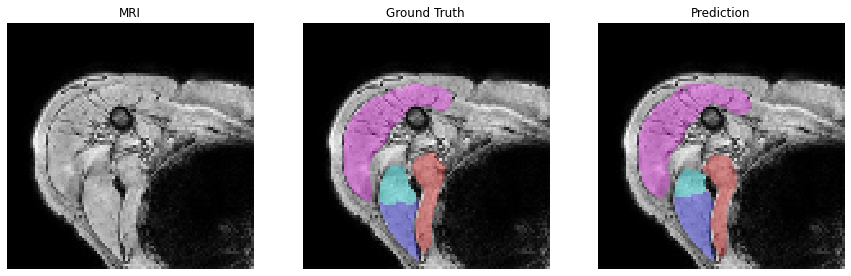

In [17]:
N_b = 0
N_e = 10
plot_compare_segmentation(X_test_e8[N_b:N_e], y_test[N_b:N_e], y_pred[N_b:N_e], " ", spacing=(1,1), step=1)

### <span style="color:red"> Question : </span>

- How the quality of this network is assessed ? what is Dice ?
- Visually consider images and the predictions, what is your qualitative assessment ?


### <span style="color:red"> Question : </span> Importance of 'device'.
- How long was the prediction time (or evaluation time)?
- This step ran on CPU. Now, change the GPU variable (1 -> 0) in the first cell of code and restart the kernel. Then run again the notebook. Compare the evaluate time. 

## <span style="color:brown"> 4.2- Evalaution with DICE/Hausdorff distance and Average symmetric surface distance
    
First, load the code.

In [18]:
from keras_unet.evaluation import  evaluate_segmentation, evaluate_set

Then perform a unique evaluation

In [19]:
#from keras_unet import evaluation
dice, hausdorff, assds = evaluate_segmentation(y_test[1], y_pred[1], voxel_spacing = [1, 1])
print("Dice:", dice)
print("hausdorff:", hausdorff)
print("assds",assds)


Dice: [0.9018450184501845, 0.8813056379821959, None, 0.9468302658486708, None, 0.8733459357277883]
hausdorff: [4.242640687119285, 3.0, None, 2.0, None, 4.242640687119285]
assds [0.5371150222392936, 0.5695061201554064, None, 0.3594184870718938, None, 0.6824204594905807]


Now, on the whole test set 

In [20]:
dice_all, hausdorff_all, assd_all, valid_all = evaluate_set(y_test, y_pred)

100%|██████████| 208/208 [00:02<00:00, 81.87it/s]


In [21]:
print("dice_all", dice_all)
print("hausdorff", hausdorff_all)
print("assd", assd_all)

dice_all [0.8719814  0.8810611  0.7116593  0.8197215  0.66995937 0.8805314 ]
hausdorff [10.284109   4.5905156  8.181599   6.6881347  5.0827565  6.133321 ]
assd [1.086656   0.7087927  1.9213305  1.2602938  1.4123349  0.95208496]


Improve the rendering for your presentation ;)

,Dice,Hausdorff,ASSD
All,0.872,10.284,1.087
1,0.881,4.591,0.709
2,0.712,8.182,1.921
3,0.820,6.688,1.260
4,0.670,5.083,1.412
5,0.881,6.133,0.952


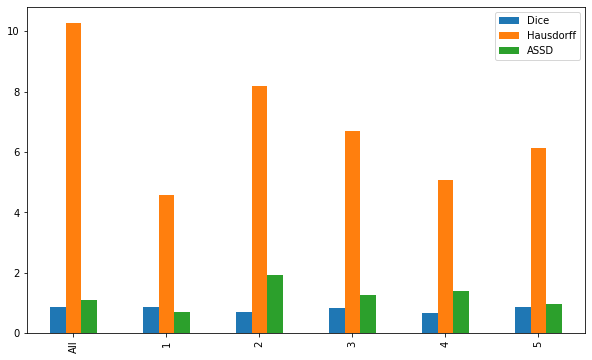

In [22]:
import pandas as pd
from IPython.display import display, HTML 

overall_results = np.column_stack((dice_all, hausdorff_all, assd_all))
#print(overall_results)

# Graft our results matrix into pandas data frames 
overall_results_df = pd.DataFrame(data=overall_results, index = ["All", "1", "2", "3", "4", "5"], 
                                  columns=["Dice", "Hausdorff", "ASSD"]) 

# Display the data as HTML tables and graphs
display(HTML(overall_results_df.to_html(float_format=lambda x: '%.3f' % x)))
overall_results_df.plot(kind='bar', figsize=(10,6)).legend() #bbox_to_anchor=(1.6,0.9))


Or to your paper (latex) :

In [23]:
#print(overall_results_df.to_latex(float_format=lambda x: '%.3f' % x)) # column_format='cccc'

# max Dice value in blod:
latex_tab = overall_results_df.style.highlight_max( props='textbf:--rwrap;', subset=["Dice"])
       
# min "Hausdorff", "ASSD" in bold
latex_tab.highlight_min( props='textbf:--rwrap;', subset=["Hausdorff", "ASSD"])

#limit decimal do different precision
latex_tab.format({
   "Dice": '{:.2f}',
   "Hausdorff": '{:.1f}',
   "ASSD": '{:.3f}'
})  

# generate latex code
print( latex_tab.to_latex(
    column_format="cccc", position="h", position_float="centering",
    hrules=True, label="table:SegmentationResults", caption="Averaged DSC, HD and ASSD on the test set",
    multirow_align="t", multicol_align="r")  )

\begin{table}[h]
\centering
\caption{Averaged DSC, HD and ASSD on the test set}
\label{table:SegmentationResults}
\begin{tabular}{cccc}
\toprule
 & Dice & Hausdorff & ASSD \\
\midrule
All & 0.87 & 10.3 & 1.087 \\
1 & \textbf{0.88} & \textbf{4.6} & \textbf{0.709} \\
2 & 0.71 & 8.2 & 1.921 \\
3 & 0.82 & 6.7 & 1.260 \\
4 & 0.67 & 5.1 & 1.412 \\
5 & 0.88 & 6.1 & 0.952 \\
\bottomrule
\end{tabular}
\end{table}



<span style="color:brown"> **Now :  1- Shutdown the Kernel**
    
    (menu --> Kernel --> " Shut down kernel..." )
    
    This will stop the kernel and free the ressources allocated (GPU memory...)
    
<span style="color:brown"> **Then : 2-  go to 2_UNET_TF2_train notebook to train your UNet!**